In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Self-homodyne Kerr Hamiltonian
$$
\hbar^{-1}\hat{H} = \Delta\hat{a}^\dagger\hat{a} 
+ U\hat{a}^\dagger\hat{a}^\dagger\hat{a}\hat{a}
+ \frac{1}{2}\Omega\left(
\hat{a}^\dagger + \hat{a}
\right)
$$

In [2]:
kappa, Omg, u = 1, 1, 1e-3 # <- change these to explore parameter regimes

In [3]:
nphotons = 10
a = qp.destroy(nphotons)
c_op = [np.sqrt(kappa)*a]    # collapse operators

# Kerr Hamiltonian at detuning det
def kerrh(det):
    return (det*a.dag()*a
            + u*a.dag()*a.dag()*a*a
            + Omg/2*(a.dag() + a))

# steady-state density matrix (generically, for any Hamiltonian/detuning)
def rho_ss(ham, c_op):
    return qp.steadystate(ham, c_op)

# <a^\dagger a>
def intensity(rho):
    return qp.expect(a.dag()*a, rho)

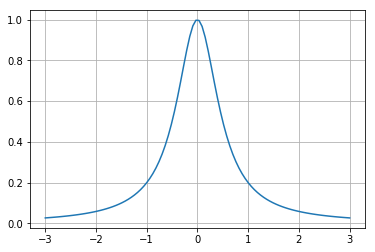

In [4]:
detunings = np.linspace(-3, 3, 100)
inty = np.vectorize(lambda det: intensity(rho_ss(kerrh(det), c_op)))(detunings)
plt.plot(detunings, inty)
plt.grid()

In [5]:
def b(alpha):
    return (a + 1j*alpha)/np.sqrt(2) # Result of beamsplitter

def g2at0(det, alpha):
    rho = rho_ss(kerrh(det), c_op)    
    numerator = qp.expect(b(alpha).dag()*b(alpha).dag()*b(alpha)*b(alpha), rho)
    denominator = qp.expect(b(alpha).dag()*b(alpha), rho)**2
    return numerator/denominator

from scipy.optimize import minimize
sol = minimize(lambda x: g2at0(x[0], x[1]+1j*x[2]), # function to minimize
               (0, 1.0, 0.0),                       # start vector
               method="Nelder-Mead")                # minimization algorithm

alphaopt = sol.x[1] + 1j*sol.x[2]

In [6]:
def g2delay(det, alpha, tvec):
    def numerator(dm):
        return qp.expect(b(alpha).dag()*b(alpha), dm)
        
    qrdmatrix = qp.mesolve(kerrh(det), 
                           b(alpha)*rho_ss(kerrh(det), c_op)*b(alpha).dag(), 
                           tvec, 
                           c_op, 
                           [], 
                           options=qp.Options(atol=1e-13,
                                              rtol=1e-11,
                                              order=12,
                                              tidy=False))
    denominator = qp.expect(b(alpha).dag()*b(alpha), 
                            rho_ss(kerrh(det), c_op))**2
    
    return np.vectorize(lambda dm: numerator(dm)/denominator)(qrdmatrix.states)

In [22]:
detunings = np.linspace(0.75, 0.85, 101)
delays = np.linspace(0, 10, 100)
g2mat = np.zeros((len(detunings), len(delays)))
for ix, det in enumerate(detunings):
    g2mat[ix, :] = g2delay(det, alphaopt, delays)

Text(0.5,1,'$(\\kappa, \\Omega, U) = (1, 1, 10^{-3})$')

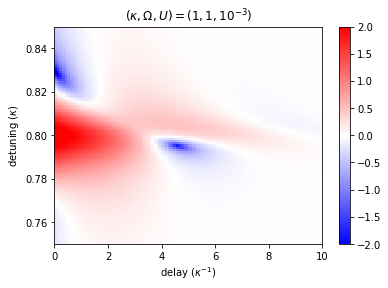

In [34]:
plt.pcolormesh(delays, detunings, np.log10(g2mat), cmap="bwr", vmin=-2, vmax=2)
plt.colorbar()
plt.xlabel("delay ($\kappa^{-1}$)")
plt.ylabel("detuning ($\kappa$)")
plt.title("$(\kappa, \Omega, U) = (1, 1, 10^{-3})$")

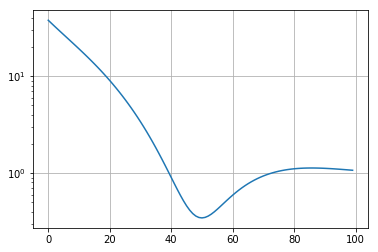

In [37]:
plt.plot(g2delay(0.79, alphaopt, delays))
plt.yscale("log")
plt.grid()

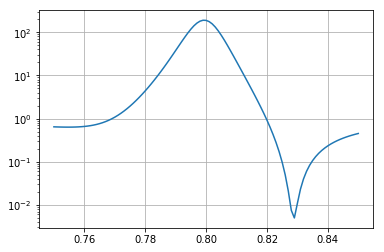

In [39]:
plt.plot(detunings, np.vectorize(lambda d: g2at0(d, alphaopt))(detunings))
plt.yscale("log")
plt.grid()

In [28]:
sol.x

array([ 0.82871449,  0.27864672, -0.45365512])